![Add a relevant banner image here](path_to_image)

# Project Title

## Overview

Short project description. Your bottom line up front (BLUF) insights.

## Business Understanding

Text here

## Data Understanding

Text here

In [1]:
# Load relevant imports here
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import kagglehub

In [2]:
df_all_data = pd.read_csv('Data/US_Accidents_March23.csv')
print(df_all_data.describe())
print(df_all_data.head())
print(df_all_data.columns)

           Severity     Start_Lat     Start_Lng       End_Lat       End_Lng  \
count  7.728394e+06  7.728394e+06  7.728394e+06  4.325632e+06  4.325632e+06   
mean   2.212384e+00  3.620119e+01 -9.470255e+01  3.626183e+01 -9.572557e+01   
std    4.875313e-01  5.076079e+00  1.739176e+01  5.272905e+00  1.810793e+01   
min    1.000000e+00  2.455480e+01 -1.246238e+02  2.456601e+01 -1.245457e+02   
25%    2.000000e+00  3.339963e+01 -1.172194e+02  3.346207e+01 -1.177543e+02   
50%    2.000000e+00  3.582397e+01 -8.776662e+01  3.618349e+01 -8.802789e+01   
75%    2.000000e+00  4.008496e+01 -8.035368e+01  4.017892e+01 -8.024709e+01   
max    4.000000e+00  4.900220e+01 -6.711317e+01  4.907500e+01 -6.710924e+01   

       Distance(mi)  Temperature(F)  Wind_Chill(F)   Humidity(%)  \
count  7.728394e+06    7.564541e+06   5.729375e+06  7.554250e+06   
mean   5.618423e-01    6.166329e+01   5.825105e+01  6.483104e+01   
std    1.776811e+00    1.901365e+01   2.238983e+01  2.282097e+01   
min    0.000000e

In [3]:
df_severity_by_state = pd.crosstab(df_all_data['Severity'], df_all_data['State'])
df_severity_by_state.head()

State,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
Severity,,,,,,,,,,,,,,,,,,,,,
1,681,37,7389,10284,970,72,143,234,7083,1007,...,0,2335,4233,632,3115,3,865,90,2,0
2,76993,19239,140553,1445833,56105,50392,16489,11596,755895,94206,...,221,133054,450952,79801,230660,616,73339,21530,12444,3028
3,21542,677,17551,271814,26306,16369,1177,715,104065,61245,...,8,28510,120443,15000,51324,217,29926,9606,524,182
4,1828,2827,5116,13502,7504,4172,821,1552,13149,12776,...,60,3489,7209,1646,18202,90,4091,3462,823,547


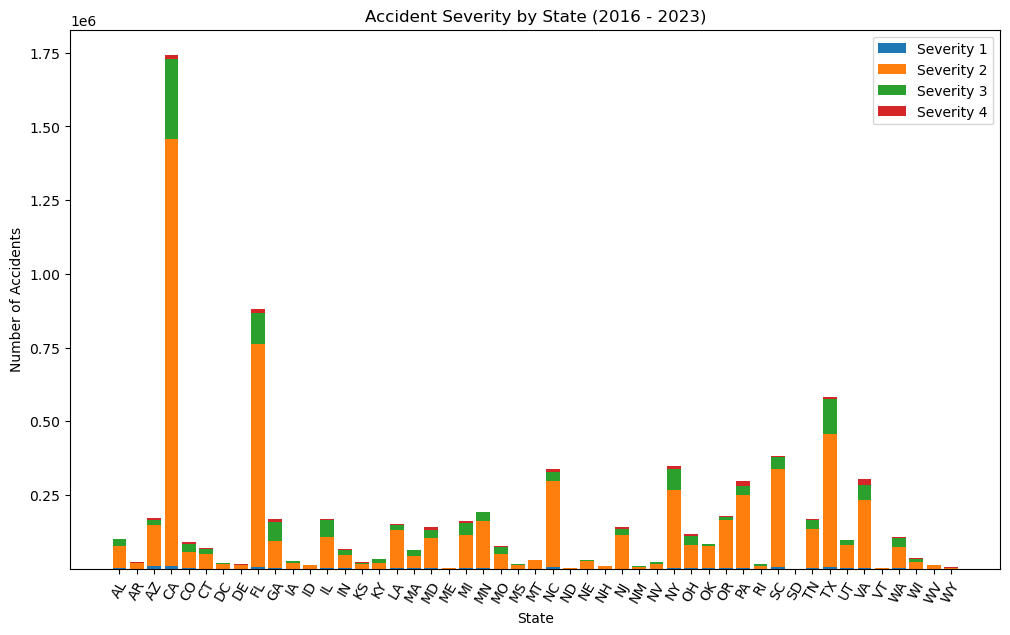

In [4]:
# chart of accident severity by state
states = df_severity_by_state.columns
sev1 = df_severity_by_state.iloc[0]
sev2 = df_severity_by_state.iloc[1]
sev3 = df_severity_by_state.iloc[2]
sev4 = ct_sev4_by_state = df_severity_by_state.iloc[3]

plt.figure(figsize=(12, 7))
plt.bar(states, sev1)
plt.bar(states, sev2, bottom=sev1)
plt.bar(states, sev3, bottom=sev1+sev2)
plt.bar(states, sev4, bottom=sev1+sev2+sev3)
plt.xlabel("State")
plt.xticks(rotation=60)
plt.ylabel("Number of Accidents")
plt.legend(["Severity 1", "Severity 2", "Severity 3", "Severity 4"])
plt.title("Accident Severity by State (2016 - 2023)")
plt.show()

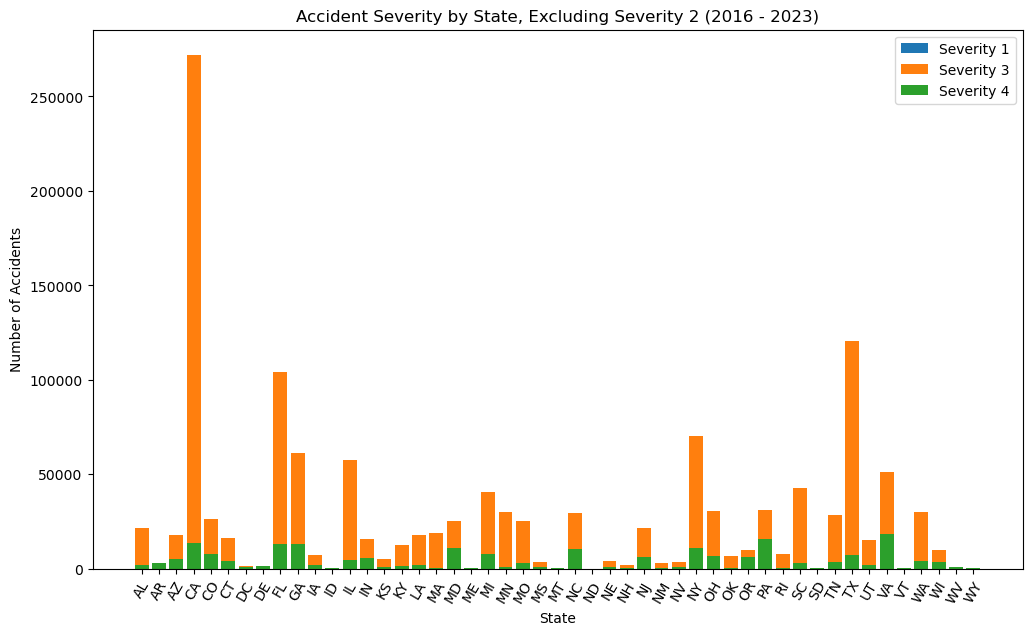

In [5]:
# chart of accident severity by state without sev2 (sev 2 >> than the others so obscures sev 1, 3, 4 above)
states = df_severity_by_state.columns
sev1 = df_severity_by_state.iloc[0]
sev3 = df_severity_by_state.iloc[2]
sev4 = ct_sev4_by_state = df_severity_by_state.iloc[3]

plt.figure(figsize=(12, 7))
plt.bar(states, sev1)
plt.bar(states, sev3)
plt.bar(states, sev4)
plt.xlabel("State")
plt.xticks(rotation=60)
plt.ylabel("Number of Accidents")
plt.legend(["Severity 1", "Severity 3", "Severity 4"])
plt.title("Accident Severity by State, Excluding Severity 2 (2016 - 2023)")
plt.show()

In [6]:
df_sev_by_crossing = pd.crosstab(df_all_data['Severity'], df_all_data['Crossing'])
df_sev_by_crossing = df_sev_by_crossing.rename(columns={False: "No", True: "Yes"})
df_sev_by_crossing.head()

Crossing,No,Yes
Severity,,
1,48675,18691
2,5363435,793546
3,1251305,48032
4,191216,13494


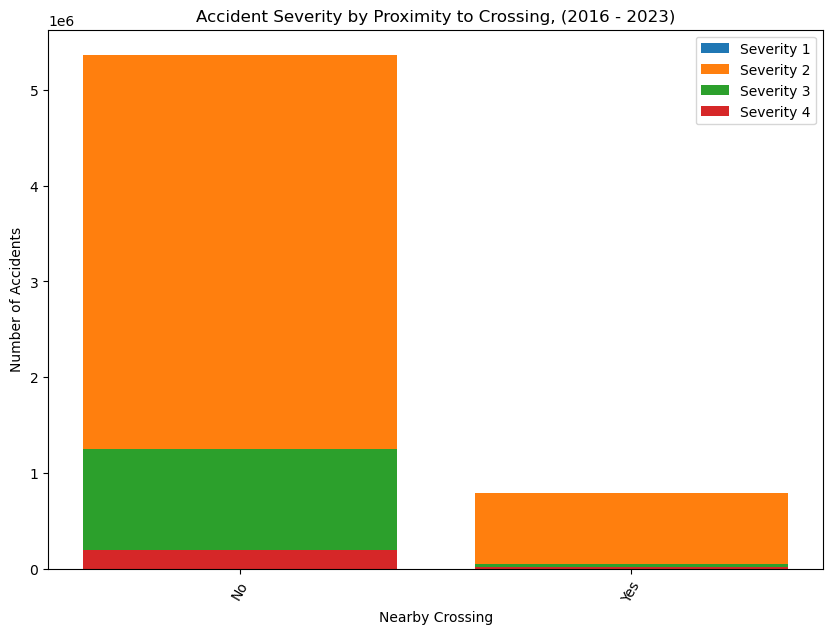

In [7]:
# charts of accident severity by bump, traffic calming, roundabout
# chart of accident severity by state
crossing = df_sev_by_crossing.columns
cr1 = df_sev_by_crossing.iloc[0]
cr2 = df_sev_by_crossing.iloc[1]
cr3 = df_sev_by_crossing.iloc[2]
cr4 = df_sev_by_crossing.iloc[3]

plt.figure(figsize=(10, 7))
plt.bar(crossing, cr1)
plt.bar(crossing, cr2)
plt.bar(crossing, cr3)
plt.bar(crossing, cr4)
plt.xticks(rotation=60)
plt.xlabel("Nearby Crossing")
plt.ylabel("Number of Accidents")
plt.legend(["Severity 1", "Severity 2", "Severity 3", "Severity 4"])
plt.title("Accident Severity by Proximity to Crossing, (2016 - 2023)")
plt.show()

In [ ]:
print(f"Count of Wind Direction Entries: {df_all_data['Wind_Direction'].nunique()}")


Count of Wind Direction Entries: 24


In [ ]:
df_all_data['Start_Time'] = pd.to_datetime(df_all_data['Start_Time'], format="mixed")
df_all_data['Start_time_only'] = df_all_data['Start_Time'].dt.time

In [11]:
df_all_data['Weather_Timestamp'] = pd.to_datetime(df_all_data['Weather_Timestamp'], format="mixed")
df_all_data['Weather_timestamp_only'] = df_all_data['Weather_Timestamp'].dt.time

In [20]:
df_all_data.describe()

,Severity,Start_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,7.728394e+06,7728394,7.728394e+06,7.728394e+06,4.325632e+06,4.325632e+06,7.728394e+06,7608166,7.564541e+06,5.729375e+06,7.554250e+06,7.587715e+06,7.551296e+06,7.157161e+06,5.524808e+06
mean,2.212384e+00,2020-06-04 04:23:22.765653760,3.620119e+01,-9.470255e+01,3.626183e+01,-9.572557e+01,5.618423e-01,2020-06-02 10:06:41.888674560,6.166329e+01,5.825105e+01,6.483104e+01,2.953899e+01,9.090376e+00,7.685490e+00,8.407210e-03
min,1.000000e+00,2016-01-14 20:18:33,2.455480e+01,-1.246238e+02,2.456601e+01,-1.245457e+02,0.000000e+00,2016-01-14 19:51:00,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,2018-11-23 04:01:12.249999872,3.339963e+01,-1.172194e+02,3.346207e+01,-1.177543e+02,0.000000e+00,2018-11-20 18:35:00,4.900000e+01,4.300000e+01,4.800000e+01,2.937000e+01,1.000000e+01,4.600000e+00,0.000000e+00
50%,2.000000e+00,2020-11-11 08:40:22,3.582397e+01,-8.776662e+01,3.618349e+01,-8.802789e+01,3.000000e-02,2020-11-10 13:53:00,6.400000e+01,6.200000e+01,6.700000e+01,2.986000e+01,1.000000e+01,7.000000e+00,0.000000e+00
75%,2.000000e+00,2022-01-20 07:30:08.500000,4.008496e+01,-8.035368e+01,4.017892e+01,-8.024709e+01,4.640000e-01,2022-01-19 14:27:00,7.600000e+01,7.500000e+01,8.400000e+01,3.003000e+01,1.000000e+01,1.040000e+01,0.000000e+00
max,4.000000e+00,2023-03-31 23:30:00,4.900220e+01,-6.711317e+01,4.907500e+01,-6.710924e+01,4.417500e+02,2023-03-31 23:53:00,2.070000e+02,2.070000e+02,1.000000e+02,5.863000e+01,1.400000e+02,1.087000e+03,3.647000e+01
std,4.875313e-01,NaN,5.076079e+00,1.739176e+01,5.272905e+00,1.810793e+01,1.776811e+00,NaN,1.901365e+01,2.238983e+01,2.282097e+01,1.006190e+00,2.688316e+00,5.424983e+00,1.102246e-01


In [ ]:
plt.scatter(acc_time, wthr_time)
plt.title("Time of Accident vs. Weather Timestamp")
plt.xlabel("Time of Accident")
plt.ylabel("Weather Timestamp")
plt.show()

TypeError: cannot convert the series to <class 'int'>

## Data Preparation

### Data Selection

Based on my exploration of the data, I'm removing the following fields from the dataset for the following reasons:

- Source: contains information that has no relationship to causes and effects of accidents
- Timezone: duplicates zip/state with less precision
- Country: all data is from the United States so this field is redundant
- Airport_Code: doesn't provide germane information-the exact location where weather conditions are reported is not a variable that can be adjusted
- Wind_Direction: too many unique values that are not related to travel directions to produce clear/actionable conclusions


In [9]:
df_refined = df_all_data.drop(['Source', 'Timezone', 'Country', 'Airport_Code', 'Wind_Direction'], axis=1)

print(df_refined.describe())
print(df_refined.columns)

           Severity     Start_Lat     Start_Lng       End_Lat       End_Lng  \
count  7.728394e+06  7.728394e+06  7.728394e+06  4.325632e+06  4.325632e+06   
mean   2.212384e+00  3.620119e+01 -9.470255e+01  3.626183e+01 -9.572557e+01   
std    4.875313e-01  5.076079e+00  1.739176e+01  5.272905e+00  1.810793e+01   
min    1.000000e+00  2.455480e+01 -1.246238e+02  2.456601e+01 -1.245457e+02   
25%    2.000000e+00  3.339963e+01 -1.172194e+02  3.346207e+01 -1.177543e+02   
50%    2.000000e+00  3.582397e+01 -8.776662e+01  3.618349e+01 -8.802789e+01   
75%    2.000000e+00  4.008496e+01 -8.035368e+01  4.017892e+01 -8.024709e+01   
max    4.000000e+00  4.900220e+01 -6.711317e+01  4.907500e+01 -6.710924e+01   

       Distance(mi)  Temperature(F)  Wind_Chill(F)   Humidity(%)  \
count  7.728394e+06    7.564541e+06   5.729375e+06  7.554250e+06   
mean   5.618423e-01    6.166329e+01   5.825105e+01  6.483104e+01   
std    1.776811e+00    1.901365e+01   2.238983e+01  2.282097e+01   
min    0.000000e

### Data Cleaning

##### Missing Values

In [10]:
#print(f"Count of Unique Weather Condition Entries: {df_all_data['Weather_Condition'].nunique()}")
df_refined['Weather_Condition'].value_counts().sort_values(ascending=True)



Weather_Condition
Drifting Snow                1
Dust Whirls                  1
Heavy Smoke                  1
Partial Fog / Windy          1
Blowing Snow Nearby          1
                        ...   
Partly Cloudy           698972
Clear                   808743
Cloudy                  817082
Mostly Cloudy          1016195
Fair                   2560802
Name: count, Length: 144, dtype: int64

## Analysis

Text here

## Evaluation

### Business Insight/Recommendation 1

### Business Insight/Recommendation 2

### Business Insight/Recommendation 3

### Tableau Dashboard link

## Conclusion and Next Steps
Text here